In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

## Ideal

In [2]:
%run sun.py

In [3]:
def I_t(el):
    # negative elevation not meaningful
    el2 = el.copy()
    el2[el2<0] = 0
    AM = 1/np.cos(np.radians(90-el2))
    I = 1.1*(1353*0.7**AM**0.678)
    return I

In [4]:
def inc_ang(beta, panel_az, el, az):
    
    beta = np.radians(beta)
    panel_az = np.radians(panel_az)
    zen = np.radians(90 - el)
    azrad = np.radians(az)
    
    arg = np.cos(beta)*np.cos(zen)+ \
            np.sin(beta)*np.sin(zen)*np.cos(azrad-panel_az)
    deg = np.degrees(np.arccos(arg))
    
    # max value is 90, means output is zero 
    deg[deg>90] = 90
    
    return deg

In [5]:
def current(el, area):
    a_m2 = area/10000
    power = I_t(el)*a_m2*0.2 # energy/area * area * efficiency
    current = power/5 #volts
    return current*1000

In [6]:
# Provided functions

#arguments in degrees
#beta_ax: beta of axis 
# az_ax: axis azimuth
# el: elevation of sun
# az: azimuth of sun
# limit: how far can the panel rotate in each direction? (default 90 i.e. can rotate 180 total)
def R_opt(beta_ax, az_ax, el, az,limit=90):
    beta_ax = np.radians(beta_ax)
    az_ax = np.radians(az_ax)
    
    zen = np.radians(90 - el)
    
    azrad = np.radians(az)
        
    arg = np.sin(zen)*np.sin(azrad-az_ax)/ \
            (np.sin(zen)*np.cos(azrad-az_ax)*np.sin(beta_ax) \
             + np.cos(zen)*np.cos(beta_ax))
    
    phi = np.where((arg < 0) & ((azrad-az_ax) > 0) , 180, 
            np.where((arg > 0) & ((azrad-az_ax) < 0), -180,0))
    
    
    R = np.degrees(np.arctan(arg)) + phi
    
    R[R>90] = limit
    R[R<-90] = -limit
    
    return R

def surface_beta(R, beta_ax):
    beta_ax = np.radians(beta_ax)
    Rrad = np.radians(R)
    beta = np.arccos(np.cos(Rrad)*np.cos(beta_ax))
    return np.degrees(beta)

# must calculate surface_beta first
def surface_azimuth(R, beta, az_ax):
    Rrad = np.radians(R)
    beta_rad = np.radians(beta)
    az_ax = np.radians(az_ax)
    
    surface_az = az_ax + np.arcsin(np.sin(Rrad)/np.sin(beta_rad))
    return np.degrees(surface_az)
    

def inc_SA(R, beta_ax, az_ax, el, az): 
    assert R.shape[0] == el.shape[0]
    R = np.radians(R)
    beta_ax = np.radians(beta_ax)
    az_ax = np.radians(az_ax)
    el = np.radians(90-el)
    az = np.radians(az)
    
    arg = np.cos(R)*(np.sin(el)*np.cos(az-az_ax)*np.sin(beta_ax) \
                    +np.cos(el)*np.cos(beta_ax)) + \
                    np.sin(R)*np.sin(el)*np.sin(az-az_ax)
    return np.degrees(np.arccos(arg))

## Single axis

In [7]:
# current time, voltage (V), current (mA), power (mW)
single_df = pd.read_csv('single_axis_0714.csv', header=None, names=['Time', 'Voltage', 'Current', 'Power'])
single_df['Time'] = pd.to_datetime(single_df['Time'], format='%H:%M:%S')

In [8]:
# Extract the minute component from the 'Time' column
single_df['Minute'] = single_df['Time'].dt.strftime('%H:%M')

# Calculate the average power for each minute
average_single_df = single_df.groupby('Minute')['Power'].mean().reset_index()


In [9]:
A = 39.2
beta = 50
panel_az = 180
time_zone = 4
voltage = 6
single_sp = np.array([sunPosition(2023,7,14,int(t.split(':')[0])+time_zone,int(t.split(':')[1])) 
                      for t in average_single_df['Minute']])
single_ideal = current(single_sp[:,1], A) * voltage
cos_theta = np.cos(np.radians(inc_ang(beta, panel_az, single_sp[:,1],single_sp[:,0])))
single_ideal_fixed = single_ideal * cos_theta


R = R_opt(beta,panel_az,single_sp[:,1],single_sp[:,0])
cos_theta = np.cos(np.radians(inc_SA(R, beta, panel_az, single_sp[:,1], single_sp[:,0])))

single_ideal_single = single_ideal * cos_theta

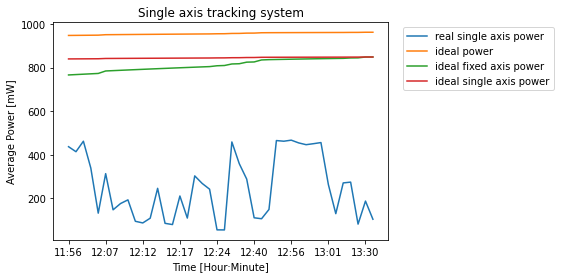

In [30]:
# Plot the time against the average power
plt.plot(average_single_df['Minute'], average_single_df['Power'], label="real single axis power")
plt.plot(average_single_df['Minute'], single_ideal, label="ideal power")
plt.plot(average_single_df['Minute'], single_ideal_fixed, label="ideal fixed axis power")
plt.plot(average_single_df['Minute'], single_ideal_single, label="ideal single axis power")
plt.xlabel('Time [Hour:Minute]')
plt.ylabel('Average Power [mW]')
plt.title('Single axis tracking system')
plt.xticks(np.arange(0, len(average_single_df['Minute'])+1, 5))
plt.legend(loc='upper right', bbox_to_anchor=(1.51, 1))
plt.show()

In [11]:
interval_list = []
prev_t = datetime.strptime('11:55', "%H:%M")
for t in average_single_df['Minute']:
    t = datetime.strptime(t, "%H:%M")
    interval_list.append((t-prev_t).total_seconds()/60)
    prev_t = t


interval_list
interval_list.pop(0)
interval_list.append(1.0)

total_single_real = 0
total_single_ideal = 0
total_single_ideal_fixed = 0
total_single_ideal_single = 0

for interval, real, ideal, ideal_fixed, ideal_single in zip(interval_list,average_single_df['Power'],single_ideal,single_ideal_fixed,single_ideal_single):
    total_single_real += real*interval
    total_single_ideal += ideal*interval
    total_single_ideal_fixed += ideal_fixed*interval
    total_single_ideal_single += ideal_single*interval

print(f"Total power captured by single axis tracking: {total_single_real}")
print(f"Ideal power: {total_single_ideal}")
print(f"Ideal fixed axis power: {total_single_ideal_fixed}")
print(f"Ideal single axis power: {total_single_ideal_single}")
print()
print(f"Overall % power loss (vs ideal): {(total_single_ideal - total_single_real) / total_single_ideal}")
print(f"Overall % power loss (vs ideal single axis): {(total_single_ideal_single - total_single_real) / total_single_ideal_single}")

Total power captured by single axis tracking: 17940.309637706934
Ideal power: 91881.32122458947
Ideal fixed axis power: 78676.12772983364
Ideal single axis power: 81163.34210383396

Overall % power loss (vs ideal): 0.8047447577091903
Overall % power loss (vs ideal single axis): 0.7789604374009695


## Fixed axis

In [12]:
# current time, voltage (V), current (mA), power (mW)
fixed_df = pd.read_csv('fixed_axis_0714.csv', header=None, names=['Time', 'Voltage', 'Current', 'Power'])
fixed_df['Time'] = pd.to_datetime(fixed_df['Time'], format='%H:%M:%S')

In [13]:
# Extract the minute component from the 'Time' column
fixed_df['Minute'] = fixed_df['Time'].dt.strftime('%H:%M')

# Calculate the average power for each minute
average_fixed_df = fixed_df.groupby('Minute')['Power'].mean().reset_index()


In [14]:
A = 39.2
beta = 50
panel_az = 180
time_zone = 4
voltage = 6
fixed_sp = np.array([sunPosition(2023,7,14,int(t.split(':')[0])+time_zone,int(t.split(':')[1])) 
                      for t in average_fixed_df['Minute']])
fixed_ideal = current(fixed_sp[:,1], A) * voltage
cos_theta = np.cos(np.radians(inc_ang(beta, panel_az, fixed_sp[:,1],fixed_sp[:,0])))
fixed_ideal_fixed = fixed_ideal * cos_theta


R = R_opt(beta,panel_az,fixed_sp[:,1],fixed_sp[:,0])
cos_theta = np.cos(np.radians(inc_SA(R, beta, panel_az, fixed_sp[:,1], fixed_sp[:,0])))

fixed_ideal_single = fixed_ideal * cos_theta

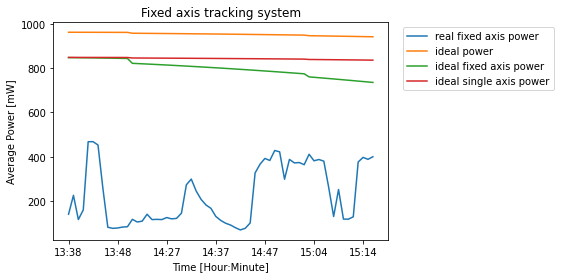

In [32]:
# Plot the time against the average power
plt.plot(average_fixed_df['Minute'], average_fixed_df['Power'], label="real fixed axis power")
plt.plot(average_fixed_df['Minute'], fixed_ideal, label="ideal power")
plt.plot(average_fixed_df['Minute'], fixed_ideal_fixed, label="ideal fixed axis power")
plt.plot(average_fixed_df['Minute'], fixed_ideal_single, label="ideal single axis power")
plt.xlabel('Time [Hour:Minute]')
plt.ylabel('Average Power [mW]')
plt.title('Fixed axis tracking system')
plt.xticks(np.arange(0, len(average_fixed_df['Minute'])+1, 10))
plt.legend(loc='upper right', bbox_to_anchor=(1.51, 1))
plt.show()

In [16]:
interval_list = []
prev_t = datetime.strptime('13:37', "%H:%M")
for t in average_fixed_df['Minute']:
    t = datetime.strptime(t, "%H:%M")
    interval_list.append((t-prev_t).total_seconds()/60)
    prev_t = t


interval_list
interval_list.pop(0)
interval_list.append(1.0)

total_fixed_real = 0
total_fixed_ideal = 0
total_fixed_ideal_fixed = 0
total_fixed_ideal_single = 0

for interval, real, ideal, ideal_fixed, ideal_single in zip(interval_list,average_single_df['Power'],single_ideal,single_ideal_fixed,single_ideal_single):
    total_fixed_real += real*interval
    total_fixed_ideal += ideal*interval
    total_fixed_ideal_fixed += ideal_fixed*interval
    total_fixed_ideal_single += ideal_single*interval

print(f"Total power captured by fixed axis tracking: {total_fixed_real}")
print(f"Ideal power: {total_fixed_ideal}")
print(f"Ideal fixed axis power: {total_fixed_ideal_fixed}")
print(f"Ideal single axis power: {total_fixed_ideal_single}")
print()
print(f"Overall % power loss (vs ideal): {(total_fixed_ideal - total_fixed_real) / total_fixed_ideal}")
print(f"Overall % power loss (vs ideal fixed axis): {(total_fixed_ideal_fixed - total_fixed_real) / total_fixed_ideal_fixed}")

Total power captured by fixed axis tracking: 17642.001853256974
Ideal power: 67775.13383621923
Ideal fixed axis power: 57171.83653454259
Ideal single axis power: 59920.36745117595

Overall % power loss (vs ideal): 0.7396980152648693
Overall % power loss (vs ideal fixed axis): 0.6914214598896457
